# Neural/Variational Method

In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
from src.eigensolver.neural.neural_eigensolver import NeuralSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.neural.network.feedforward import FeedForwardNetwork, ConstantFFN, ConstantLinearFFN
from src.eigensolver.neural.loss.orth_loss import BasicOrthogonalityLoss, CovOrthogonalityLoss
from src.eigensolver.neural.loss.variational_loss import VariationalLoss
from torch.utils.data import Dataset, DataLoader
from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

In [4]:
metrics = ['eigenvalue_mse','eigenfunc_mse','orth_error','fitted_eigenvalue_mse','eigen_error','fitted_eigen_error']

In [5]:
from torch.optim.lr_scheduler import LambdaLR

def combined_scheduler(step, warmup_steps, total_steps, max_lr):
    if step < warmup_steps:
        return max_lr * step / warmup_steps  # Linear warmup
    # Cosine decay after warmup
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return max_lr / 2 * (1 + np.cos(np.pi * progress))

In [6]:
def neural_experiment(energy, model, params):
    np.random.seed(42)
    dim = params['dim']
    x = energy.exact_sample((1000000,))

    max_lr = 5e-3
    # optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.8)  # SGD with momentum
    optimizer = optim.Adam(model.parameters(), lr = 1.0) # ADAM

    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    num_epochs = params.get('num_epochs')
    warmup_steps = params.get('warmup_steps')
    
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: combined_scheduler(step, warmup_steps, num_epochs, max_lr))

    solver = NeuralSolver(energy, x, model, optimizer, params, scheduler=scheduler)

    logged_metrics = np.zeros([num_epochs, len(metrics)+1])

    progress_bar = tqdm(range(num_epochs), desc=f"Training: ", leave=True)

    for epoch in progress_bar:
        loss = solver.train_epoch()
        solver.compute_eigfuncs()

        out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = params['k'])
        for metric in metrics:
            out[metric] = out[metric][-1]
        out['loss'] = loss
        logged_metrics[epoch, 0] = loss
        logged_metrics[epoch, 1:] = [out[metric] for metric in metrics]

        progress_bar.set_postfix(loss=f"{loss:.4f}")
        
    df = pd.DataFrame(logged_metrics, columns = ['loss'] + metrics)

    return x, solver, df

d = 2, first 6 eigenfunctions (eigval 0,1,2)

In [7]:
dim = 2
k = 10

params = {
    'dim': dim,
    'k': k,
    'num_epochs': 30,
    'beta': 0.3,
    'batch_size': 10000,
    'device': 'cuda:1',
    'num_samples': 100000,
    'warmup_steps': 15
}

energy = QuadraticEnergy(torch.eye(dim))

model = ConstantFFN([dim,200,200,k])

In [8]:
x, solver, df = neural_experiment(energy, model, params)

Training: 100%|██████████| 30/30 [01:41<00:00,  3.38s/it, loss=4.9896]


In [11]:
# compute theoretical min loss
minimizer_norms = torch.sqrt(torch.maximum(torch.zeros(k),1-energy.exact_eigvals(k)*params['beta']/2))

var_loss = torch.sum(params['beta'] * minimizer_norms**2 * energy.exact_eigvals(k))
orth_loss = torch.sum((1-minimizer_norms**2)**2)
opt_loss = var_loss + orth_loss

In [12]:
def plot_loss(metric):
    plt.plot(df[metric])
    if 'reconstruction' not in metric and metric != 'loss':
        plt.yscale('log')
    elif 'reconstruction' in metric:
        plt.ylim(0,1)
    elif metric == 'loss':
        plt.hlines(opt_loss, 0, len(df), color='black', ls='--', label='theoretical min loss')
        plt.legend()
    plt.title(metric)
    plt.xlabel('Epoch')

widgets.interact(plot_loss, metric=['loss']+metrics)

interactive(children=(Dropdown(description='metric', options=('loss', 'eigenvalue_mse', 'eigenfunc_mse', 'orth…

<function __main__.plot_loss(metric)>

In [13]:
evaluator = EigenEvaluator(energy)
x_eval = energy.exact_sample((10000,))

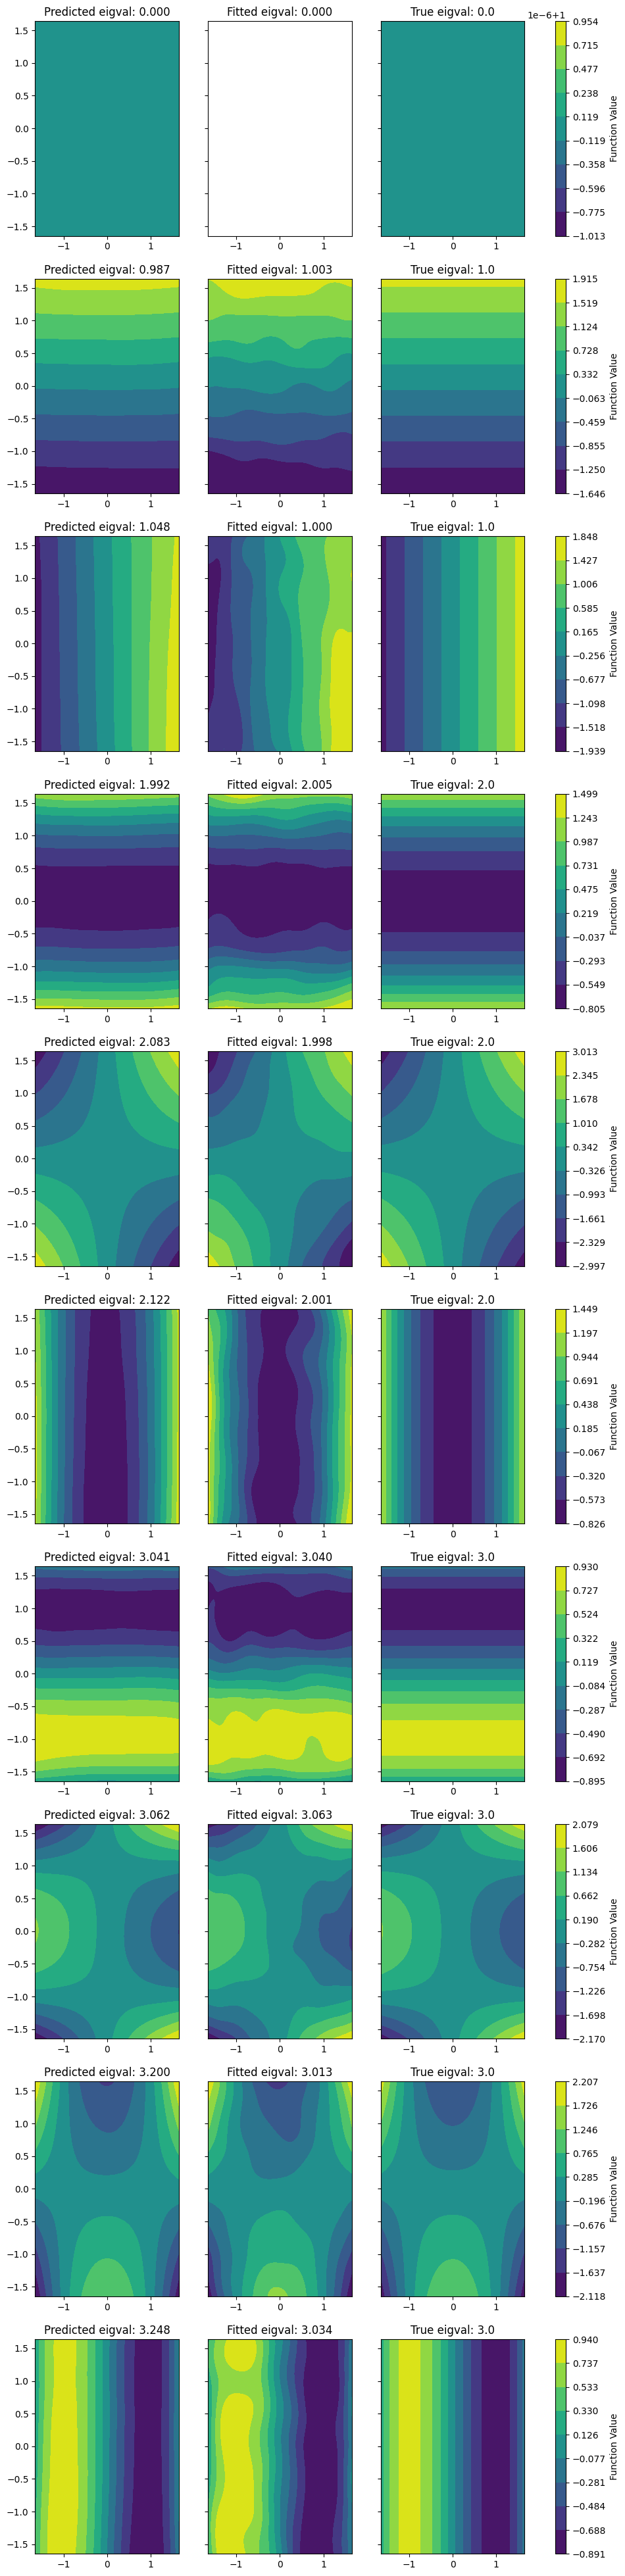

In [15]:
_ = evaluator.plot(solver,x_eval,k,plot_Lf=True,plot_exact=True)

In [161]:
def func(x):
    return (x**3).sum()

t = np.linspace(-2,2,1000)[:,None]
reconstruction_evaluator = ReconstructionEvaluator(energy, func)

error = reconstruction_evaluator.compute_reconstruction_error(x, solver.predict(x),
                                             x, solver.predict(x),
                                             solver.fitted_eigvals)
error

(array([1.        , 0.51581631, 0.41289605, 0.41223579, 0.41205766,
        0.41175856, 0.40806529, 0.37559503, 0.1990545 , 0.0046019 ]),
 array([1.        , 0.88671136, 0.86575062, 0.86784404, 0.86770532,
        0.86652219, 0.85913429, 0.79098619, 0.41498558, 0.01955311]))

In [162]:
reconstruction_evaluator.compute_reconstruction_error(x, energy.exact_eigfunctions(x,k),
                                             x, energy.exact_eigfunctions(x,k),
                                             energy.exact_eigvals(k))

(array([1.00000000e+00, 6.97368288e-01, 3.97741712e-01, 3.97731228e-01,
        3.97727605e-01, 3.97642337e-01, 1.96232975e-01, 1.96234644e-01,
        1.96203358e-01, 3.72385047e-04]),
 array([1.00000000e+00, 9.27154977e-01, 8.56599649e-01, 8.56581249e-01,
        8.56569761e-01, 8.56378476e-01, 4.22576075e-01, 4.22579658e-01,
        4.22512180e-01, 5.86425872e-04]))

(<Figure size 1000x1800 with 12 Axes>,
 array([[<Axes: title={'center': 'Reconstruction of func, err = 1.008e+00, k = 1'}>,
         <Axes: title={'center': 'Reconstruction of Lfunc, err = 1.000e+00, k = 1'}>],
        [<Axes: title={'center': 'Reconstruction of func, err = 2.029e-01, k = 2'}>,
         <Axes: title={'center': 'Reconstruction of Lfunc, err = 6.792e-01, k = 2'}>],
        [<Axes: title={'center': 'Reconstruction of func, err = 4.185e-02, k = 3'}>,
         <Axes: title={'center': 'Reconstruction of Lfunc, err = 4.361e-01, k = 3'}>],
        [<Axes: title={'center': 'Reconstruction of func, err = 1.843e-02, k = 4'}>,
         <Axes: title={'center': 'Reconstruction of Lfunc, err = 2.743e-01, k = 4'}>],
        [<Axes: title={'center': 'Reconstruction of func, err = 4.699e-03, k = 5'}>,
         <Axes: title={'center': 'Reconstruction of Lfunc, err = 9.876e-02, k = 5'}>],
        [<Axes: title={'center': 'Reconstruction of func, err = 1.529e-03, k = 6'}>,
         <Axes: 

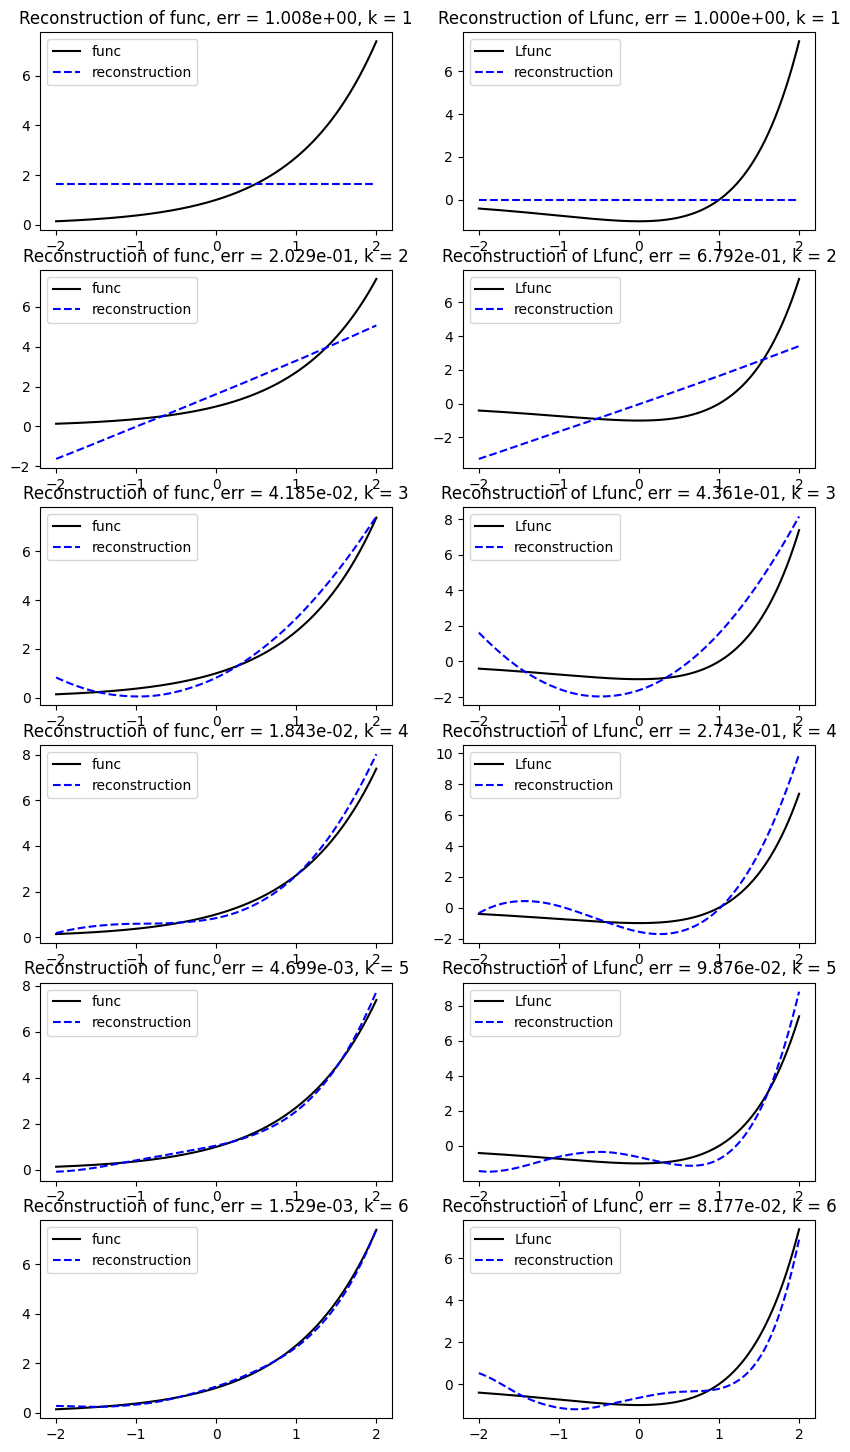

In [145]:
reconstruction_evaluator.plot_reconstruction(t, solver.predict(t),
                                             x, solver.predict(x),
                                             solver.fitted_eigvals)

### mixture

In [ ]:
metrics = ['eigen_error','orth_error','eigen_cost', 'fitted_eigen_error']

dim = 2

#means = np.array([np.zeros(dim),np.zeros(dim)])
#covs = np.array([np.diag(0.5+np.random.random(dim)),np.diag(0.5+np.random.random(dim))])

means = np.array([[0,0],[2,2]])
covs = np.array([[[1,0],[0,1]], [[1,0],[0,1]]])

#means = np.array([[0], [5]])
#covs = np.array([[[1]], [[1]]])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)
x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)


In [52]:
model = ConstantFFN([dim,10,k])

In [53]:
def func(x):
    return model(x)

hessian = torch.func.hessian(func)
laplacian = torch.vmap(lambda x: torch.diagonal(hessian(x),dim1=1,dim2=2).sum(dim=1))

In [64]:
grad = torch.func.jacrev(func)
batch_grad = torch.func.vmap(grad)

In [68]:
batch_grad(torch.tensor(x,dtype=torch.float32)).shape

torch.Size([500000, 4, 1])

In [63]:
grad(torch.tensor([1.0],requires_grad=False)).shape

torch.Size([4, 1])

In [21]:
model(torch.tensor([1.0,1.0]))

tensor([ 1.0000,  0.0925,  0.2401, -0.0968, -0.5082, -0.6885],
       grad_fn=<CatBackward0>)

In [23]:
with torch.no_grad():
    x = torch.tensor(x,device = 'cpu',dtype = torch.float32)
    print(laplacian(x).shape)

torch.Size([50000, 6])


/tmp/ipykernel_2625526/514307966.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,device = 'cpu',dtype = torch.float32)
